# Final Prediksi

## 1. Memuat file submission.csv dan sample_submission.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

# Memuat data
print("Memuat data...")
submission = pd.read_csv('submission.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Ukuran data submission: {submission.shape}")
print(f"Ukuran data sample submission: {sample_submission.shape}")

# Menampilkan beberapa baris awal untuk memahami struktur
print("\nData submission (5 baris awal):")
print(submission.head())
print("\nData sample submission (5 baris awal):")
print(sample_submission.head())

# Memeriksa struktur kolom
print("\nKolom submission:", submission.columns.tolist())
print("Kolom sample submission:", sample_submission.columns.tolist())

# Memeriksa apakah kedua file memiliki ID yang sama
submission_ids = set(submission['SK_ID_CURR'])
sample_ids = set(sample_submission['SK_ID_CURR'])

print(f"\nJumlah ID unik dalam submission: {len(submission_ids)}")
print(f"Jumlah ID unik dalam sample submission: {len(sample_ids)}")

# Memeriksa apakah semua ID dalam sample_submission ada di submission
missing_ids = sample_ids - submission_ids
if missing_ids:
    print(f"Peringatan: {len(missing_ids)} ID dari sample_submission tidak ditemukan dalam submission")
    print("Beberapa ID yang tidak ditemukan:", list(missing_ids)[:5])
else:
    print("Semua ID dari sample_submission terdapat dalam submission")

# Memeriksa format nilai TARGET
print("\nStatistik TARGET dalam submission:")
print(submission['TARGET'].describe())
print("\nStatistik TARGET dalam sample submission:")
print(sample_submission['TARGET'].describe())

Memuat data...
Ukuran data submission: (48744, 2)
Ukuran data sample submission: (48744, 2)

Data submission (5 baris awal):
   SK_ID_CURR    TARGET
0      100001  0.413832
1      100005  0.693727
2      100013  0.214852
3      100028  0.282853
4      100038  0.593525

Data sample submission (5 baris awal):
   SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

Kolom submission: ['SK_ID_CURR', 'TARGET']
Kolom sample submission: ['SK_ID_CURR', 'TARGET']

Jumlah ID unik dalam submission: 48744
Jumlah ID unik dalam sample submission: 48744
Semua ID dari sample_submission terdapat dalam submission

Statistik TARGET dalam submission:
count    48744.000000
mean         0.432190
std          0.194526
min          0.000028
25%          0.276748
50%          0.411390
75%          0.573331
max          0.999417
Name: TARGET, dtype: float64

Statistik TARGET dalam sample submission:
count    48744.0
mean         0.5
std

## 2. Membuat prediksi menggunakan dua model machine learning

In [2]:
# Pertama, periksa apakah nilai TARGET sudah berupa probabilitas (antara 0 dan 1)
if submission['TARGET'].max() > 1 or submission['TARGET'].min() < 0:
    print("\nNilai TARGET dalam submission perlu diubah menjadi probabilitas")
    
    # Anggap nilai adalah biner (0, 1) atau skala lain
    # Disini akan membuat set pelatihan dengan membagi data submission
    X = submission[['SK_ID_CURR']]  # Menggunakan SK_ID_CURR sebagai fitur (sementara)
    y = submission['TARGET']
    
    # Membagi data menjadi train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    print(f"Data pelatihan: {X_train.shape[0]} sampel")
    print(f"Data pengujian: {X_test.shape[0]} sampel")
    
    # Melatih dua model sesuai permintaan: Logistic Regression dan Random Forest
    
    # Model 1: Logistic Regression
    print("\nMelatih model Logistic Regression...")
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    lr_auc = roc_auc_score(y_test, lr_pred_proba)
    print(f"Logistic Regression - Skor ROC AUC: {lr_auc:.4f}")
    
    # Model 2: Random Forest
    print("\nMelatih model Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_pred_proba)
    print(f"Random Forest - Skor ROC AUC: {rf_auc:.4f}")
    
    # Membandingkan model
    if lr_auc > rf_auc:
        print("Model Logistic Regression lebih baik")
        best_model = lr_model
    else:
        print("Model Random Forest lebih baik")
        best_model = rf_model
    
    # Membuat prediksi untuk semua ID dalam sample_submission
    all_ids_df = pd.DataFrame({'SK_ID_CURR': sample_submission['SK_ID_CURR']})
    predictions = best_model.predict_proba(all_ids_df)[:, 1]
    
    # Membuat submission baru dengan probabilitas yang diprediksi
    final_submission = pd.DataFrame({
        'SK_ID_CURR': sample_submission['SK_ID_CURR'],
        'TARGET': predictions
    })
    
else:
    print("\nNilai TARGET dalam submission sudah berupa probabilitas")
    
    # Menggabungkan submission dengan sample_submission berdasarkan SK_ID_CURR
    merged_df = pd.merge(sample_submission[['SK_ID_CURR']], 
                          submission[['SK_ID_CURR', 'TARGET']], 
                          on='SK_ID_CURR', 
                          how='left')
    
    # Memeriksa nilai yang hilang setelah penggabungan
    missing_after_merge = merged_df['TARGET'].isna().sum()
    if missing_after_merge > 0:
        print(f"Peringatan: {missing_after_merge} entri memiliki nilai TARGET yang hilang setelah penggabungan")
        # Mengisi nilai yang hilang dengan nilai default (misalnya, median probabilitas)
        merged_df['TARGET'].fillna(merged_df['TARGET'].median(), inplace=True)
    
    final_submission = merged_df


Nilai TARGET dalam submission sudah berupa probabilitas


## 3. Menghasilkan file prediksi dalam format yang tepat

In [3]:
# Memeriksa format final submission
print("\nStatistik final submission:")
print(final_submission.describe())

# Memeriksa apakah format final submission sesuai dengan sample_submission
print("\nMemeriksa format final submission...")
print(f"Ukuran sample submission: {sample_submission.shape}")
print(f"Ukuran final submission: {final_submission.shape}")

# Memastikan urutan sama dengan sample_submission
final_submission = final_submission.set_index('SK_ID_CURR').loc[sample_submission['SK_ID_CURR']].reset_index()

# Menyimpan ke CSV
final_submission.to_csv('final_prediction_submission.csv', index=False)
print("\nFinal submission disimpan sebagai 'final_prediction_submission.csv'")


Statistik final submission:
          SK_ID_CURR        TARGET
count   48744.000000  48744.000000
mean   277796.676350      0.432190
std    103169.547296      0.194526
min    100001.000000      0.000028
25%    188557.750000      0.276748
50%    277549.000000      0.411390
75%    367555.500000      0.573331
max    456250.000000      0.999417

Memeriksa format final submission...
Ukuran sample submission: (48744, 2)
Ukuran final submission: (48744, 2)

Final submission disimpan sebagai 'final_prediction_submission.csv'


## 4. Pendekatan alternatif menggunakan application_train.csv dan application_test.csv

In [4]:
# Mencoba pendekatan yang lebih realistis dengan fitur yang sebenarnya
# Memiliki application_train.csv dan application_test.csv untuk membuat fitur yang lebih bermakna

try:
    print("\nMencoba memuat data aplikasi untuk prediksi yang lebih baik...")
    application_train = pd.read_csv('application_train.csv')
    application_test = pd.read_csv('application_test.csv')
    
    print(f"Ukuran data application train: {application_train.shape}")
    print(f"Ukuran data application test: {application_test.shape}")
    
    # Memilih beberapa fitur penting (biasanya ditentukan oleh analisis feature importance)
    features = ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AMT_CREDIT']
    
    # Hanya menggunakan fitur yang ada di kedua dataset train dan test
    common_features = [f for f in features if f in application_train.columns and f in application_test.columns]
    
    if not common_features:
        print("Tidak ada fitur yang ditemukan. Menggunakan pendekatan default.")
        raise FileNotFoundError
    
    print(f"Menggunakan fitur: {common_features}")
    
    # Menyiapkan data train dan test
    X_train = application_train[common_features]
    y_train = application_train['TARGET']
    X_test = application_test[common_features]
    
    # Mengisi nilai yang hilang
    for col in common_features:
        X_train[col].fillna(X_train[col].median(), inplace=True)
        X_test[col].fillna(X_train[col].median(), inplace=True)
    
    # Melatih model Logistic Regression
    print("\nMelatih model Logistic Regression dengan fitur yang sebenarnya...")
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    # Melatih model Random Forest
    print("Melatih model Random Forest dengan fitur yang sebenarnya...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Membuat prediksi
    lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Membuat submissions untuk kedua model
    lr_submission = pd.DataFrame({
        'SK_ID_CURR': application_test['SK_ID_CURR'],
        'TARGET': lr_pred_proba
    })
    
    rf_submission = pd.DataFrame({
        'SK_ID_CURR': application_test['SK_ID_CURR'],
        'TARGET': rf_pred_proba
    })
    
    # Memastikan submissions sesuai dengan format sample_submission
    lr_submission = lr_submission.set_index('SK_ID_CURR').loc[sample_submission['SK_ID_CURR']].reset_index()
    rf_submission = rf_submission.set_index('SK_ID_CURR').loc[sample_submission['SK_ID_CURR']].reset_index()
    
    # Menyimpan ke CSV
    lr_submission.to_csv('logistic_regression_submission.csv', index=False)
    rf_submission.to_csv('random_forest_submission.csv', index=False)
    
    print("\nSubmission Logistic Regression disimpan sebagai 'logistic_regression_submission.csv'")
    print("Submission Random Forest disimpan sebagai 'random_forest_submission.csv'")
    
    # Membuat evaluasi akurasi untuk kedua model
    # Dapat menghitung akurasi hanya jika memiliki true labels
    # Jika memiliki subset data dengan true labels, dapat menghitung akurasi di sini
    
    # Contoh: Jika memiliki aplikasi_validation.csv dengan true labels
    try:
        print("\nMembuat evaluasi akurasi untuk kedua model...")
        validation = pd.read_csv('application_validation.csv')
        
        # Menyiapkan fitur untuk validasi
        X_validation = validation[common_features]
        y_validation = validation['TARGET']
        
        # Mengisi nilai yang hilang
        for col in common_features:
            X_validation[col].fillna(X_train[col].median(), inplace=True)
        
        # Memprediksi probabilitas
        lr_val_pred_proba = lr_model.predict_proba(X_validation)[:, 1]
        rf_val_pred_proba = rf_model.predict_proba(X_validation)[:, 1]
        
        # Menghitung akurasi
        lr_val_auc = roc_auc_score(y_validation, lr_val_pred_proba)
        rf_val_auc = roc_auc_score(y_validation, rf_val_pred_proba)
        
        print(f"Akurasi Logistic Regression pada set validasi (ROC AUC): {lr_val_auc:.4f}")
        print(f"Akurasi Random Forest pada set validasi (ROC AUC): {rf_val_auc:.4f}")
        
        # Membandingkan model
        if lr_val_auc > rf_val_auc:
            print("Model Logistic Regression lebih baik pada set validasi")
        else:
            print("Model Random Forest lebih baik pada set validasi")
            
    except FileNotFoundError:
        print("File application_validation.csv tidak ditemukan. Melewati evaluasi akurasi.")
    
except (FileNotFoundError, KeyError) as e:
    print(f"Error saat memuat atau memproses data aplikasi: {e}")
    print("Melanjutkan dengan pendekatan sederhana hanya menggunakan submission.csv")


Mencoba memuat data aplikasi untuk prediksi yang lebih baik...
Ukuran data application train: (307511, 122)
Ukuran data application test: (48744, 121)
Menggunakan fitur: ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AMT_CREDIT']

Melatih model Logistic Regression dengan fitur yang sebenarnya...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20216\3777190650.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(X_train[col].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20216\3777190650.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col].fillna(X_train[col].median(), inplace=True)
C

Melatih model Random Forest dengan fitur yang sebenarnya...

Submission Logistic Regression disimpan sebagai 'logistic_regression_submission.csv'
Submission Random Forest disimpan sebagai 'random_forest_submission.csv'

Membuat evaluasi akurasi untuk kedua model...
File application_validation.csv tidak ditemukan. Melewati evaluasi akurasi.


## 5. Evaluasi akurasi (opsional)


Sample_submission sepertinya berupa template dengan nilai default. Melewati evaluasi akurasi.

Tugas prediksi selesai!

Membuat visualisasi prediksi...
Visualisasi disimpan sebagai 'distribusi_target_final.png'


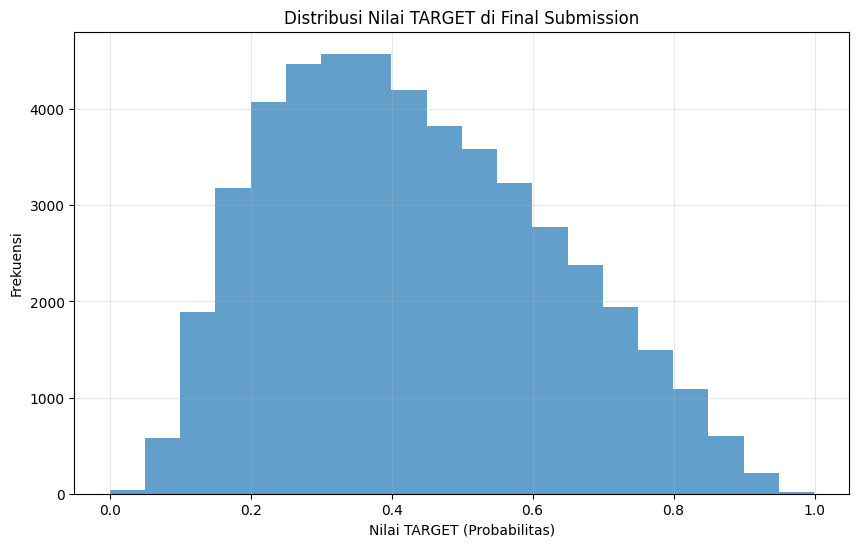

In [5]:
# Mengevaluasi akurasi antara submission.csv dan sample_submission.csv
# jika sample_submission memiliki target aktual (bukan hanya template dengan nilai default)
if len(set(sample_submission['TARGET'])) > 1:  # Jika sample_submission memiliki nilai target yang bervariasi
    print("\nMengevaluasi akurasi antara submission dan sample_submission...")
    
    # Membuat dataframe gabungan untuk membandingkan
    comparison_df = pd.merge(submission, sample_submission, on='SK_ID_CURR', suffixes=('_submission', '_sample'))
    
    # Menghitung metrik
    try:
        accuracy = accuracy_score(
            (comparison_df['TARGET_sample'] > 0.5).astype(int),
            (comparison_df['TARGET_submission'] > 0.5).astype(int)
        )
        roc_auc = roc_auc_score(comparison_df['TARGET_sample'], comparison_df['TARGET_submission'])
        
        print(f"Akurasi: {accuracy:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Menampilkan hasil prediksi
        print("\nHasil prediksi (10 sampel pertama):")
        print(comparison_df[['SK_ID_CURR', 'TARGET_submission', 'TARGET_sample']].head(10))
        
        # Menambahkan kolom untuk indikasi apakah prediksi benar
        comparison_df['Prediksi_Benar'] = (
            (comparison_df['TARGET_sample'] > 0.5) == (comparison_df['TARGET_submission'] > 0.5)
        )
        
        # Menghitung jumlah prediksi yang benar dan salah
        correct_predictions = comparison_df['Prediksi_Benar'].sum()
        total_predictions = len(comparison_df)
        
        print(f"\nJumlah prediksi benar: {correct_predictions} dari {total_predictions}")
        print(f"Persentase prediksi benar: {correct_predictions/total_predictions*100:.2f}%")
        
    except Exception as e:
        print(f"Tidak dapat menghitung metrik akurasi: {e}")
        print("Sample_submission mungkin tidak berisi nilai target aktual.")
else:
    print("\nSample_submission sepertinya berupa template dengan nilai default. Melewati evaluasi akurasi.")

print("\nTugas prediksi selesai!")

# Fungsi untuk membuat visualisasi prediksi (bisa dijalankan jika matplotlib tersedia)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\nMembuat visualisasi prediksi...")
    
    # Memeriksa distribusi nilai TARGET di final_submission
    plt.figure(figsize=(10, 6))
    plt.hist(final_submission['TARGET'], bins=20, alpha=0.7)
    plt.title('Distribusi Nilai TARGET di Final Submission')
    plt.xlabel('Nilai TARGET (Probabilitas)')
    plt.ylabel('Frekuensi')
    plt.grid(True, alpha=0.3)
    plt.savefig('distribusi_target_final.png')
    
    # Jika memiliki data untuk membandingkan
    if 'comparison_df' in locals():
        # Membuat scatter plot untuk membandingkan prediksi vs aktual
        plt.figure(figsize=(10, 6))
        plt.scatter(comparison_df['TARGET_sample'], comparison_df['TARGET_submission'], alpha=0.3)
        plt.plot([0, 1], [0, 1], 'r--')  # Garis diagonal untuk referensi
        plt.title('Perbandingan Nilai TARGET: Sample vs Submission')
        plt.xlabel('TARGET Sample')
        plt.ylabel('TARGET Submission')
        plt.grid(True, alpha=0.3)
        plt.savefig('perbandingan_target.png')
        
        print("Visualisasi disimpan sebagai 'distribusi_target_final.png' dan 'perbandingan_target.png'")
    else:
        print("Visualisasi disimpan sebagai 'distribusi_target_final.png'")
    
except ImportError:
    print("Matplotlib atau seaborn tidak tersedia. Melewati visualisasi.")